In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
from itertools import cycle
import seaborn as sns

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

%matplotlib inline

# Постановка задачи:

В данной задаче мы будем ежедневные продажи Walmart с горизонтом прогнозирования 28 дней.

Метрика прогнозирования закреплена организаторами соревнования, будем использовать ее: **Weighted RMSSE (WRMSSE)**

**Root Mean Squared Scaled Error (RMSSE):**

$$ RMSSE  = \sqrt{\frac{1}{h}\frac{\sum_{t = n + 1}^{n + h}(Y_i - \hat{Y}_i) ^ 2 }{\frac{1}{n - 1} \sum_{t=2}^{n}(Y_i - Y_{i-1}) ^ 2}},$$

где $Y_t$ - фактическое будущее значение изученного временного ряда в точке $t$, $\hat{Y}_t$  - сгенерированный прогноз, $n$ -  длина обучающей выборки (количество исторических наблюдений) и $h$ - горизонт прогнозирования.


$$ WRMSSE = \sum_{i=1}^{42840} w_i * RMSSE, $$

где $w_i$ - вес временного ряда. Чем ниже балл WRMSSE, тем лучше.

Вес каждого временного ряда будет рассчитываться на основе последних 28 наблюдений обучающей выборки набора данных, то есть совокупных фактических продаж в долларах, которые каждая серия отображала в этот конкретный период (сумма проданных единиц, умноженная на их соответствующую цену).

### Обзор доступных данных:

Датасет содержит иерархические данные о продажах Walmart, крупнейшей в мире компании по доходам. Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают уровень товара, отдел, категории продуктов и сведения о магазине. Кроме того, в нем есть пояснительные переменные, такие как цена, рекламные акции, день недели и специальные события. Вместе этот надежный набор данных можно использовать для повышения точности прогнозирования.

- calendar.csv - Содержит информацию о датах продажи товаров. Для каждой даты дана информацию о днях недели / недели / месяца / года, событиях и флагах, показывающих, разрешают ли магазины делать покупки с использованием продовольственных талонов SNAP. Данные есть за все даты.

- sales_train_validation.csv - Содержит исторические ежедневные данные о продажах (и характеристиках товаров) за единицу товара и магазина [d_1 - d_1913]. 

- sell_prices.csv - Содержит информацию о цене проданных товаров в магазине и дате.

- sales_train_evaluation.csv - содержит информацию о продажах [d_1 - d_1941]. То же самое, что sales_train_validation.csv + 28 дополнительных дней. Будем использовать эти 28 дней для валидации.

In [2]:
# Загрузка данных:

DATA_DIR = '.'
calendar_df = pd.read_csv(f'{DATA_DIR}/calendar.csv')
sales_df = pd.read_csv(f'{DATA_DIR}/sales_train_validation.csv')
sell_prices_df = pd.read_csv(f'{DATA_DIR}/sell_prices.csv')
labels_df = pd.read_csv(f'{DATA_DIR}/sales_train_evaluation.csv')

In [3]:
calendar_df.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [4]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Предварительный анализ данных

### Проверка пропущенных начений

Как видно явные  NaN значения присутствуют только в calendar_df. На самом деле, это не пропуск. С помощью NaN обозначаения отсутствие event1 или event2 в такой день. Информация о том, что в данный день не было свециального event тоже оцень полезна. Заменим значения NaN на значение NO_EVENT и будем использовать его как отдельное значение категорильных признаков.

In [6]:
calendar_df.isna().any(), sales_df.isna().any(), sell_prices_df.isna().any()

(date            False
 wm_yr_wk        False
 weekday         False
 wday            False
 month           False
 year            False
 d               False
 event_name_1     True
 event_type_1     True
 event_name_2     True
 event_type_2     True
 snap_CA         False
 snap_TX         False
 snap_WI         False
 dtype: bool, id          False
 item_id     False
 dept_id     False
 cat_id      False
 store_id    False
             ...  
 d_1909      False
 d_1910      False
 d_1911      False
 d_1912      False
 d_1913      False
 Length: 1919, dtype: bool, store_id      False
 item_id       False
 wm_yr_wk      False
 sell_price    False
 dtype: bool)

In [7]:
calendar_df[calendar_df.event_name_1.isna() == False].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0


In [8]:
calendar_df.fillna('NO_EVENT', inplace=True)

### Детальный анализ признаков

*calendar_df:*

- date, wm_yr_wk - дата, числовой или может быть преобразован к числовому
- weekday, wday - день недели, числовой или может быть преобразован к числовому (так же можно использовать категории)
- month, year, d - месяц, год, день, числовой или может быть преобразован к числовому
- event_name_1, event_name_2 - название особого мероприятия в данный день, категориальный
- event_type_1, event_type_2 - тип особого мероприятия в данный день, категориальный
- snap_CA, snap_TX, snap_WI - бинарные переменные, затрагивают ли данные event соответствующие штаты

*sales_df:*

- item_id, dept_id, cat_id - категориальные переменные, связанные с товаром, отделом, который его продает и его категорией
- store_id, state_id - категориальные переменные, связанные с магазином и штатом, в котором продается данный товар
- d_N - информация по продажам в данный день, числовой

*sell_prices_df:*

- store_id, item_id - id магазина и предмета, категориальный
- wm_yr_wk - дата, числовой или может быть преобразован к числовому
- sell_price - стоимость предмета, числовой


In [9]:
print(calendar_df.dtypes)
print('_____________________')
print(sales_df.dtypes)
print('_____________________')
print(sell_prices_df.dtypes)

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object
_____________________
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object
_____________________
store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object


### Визуализация данных

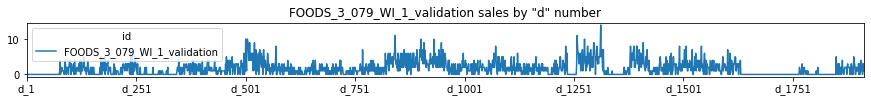

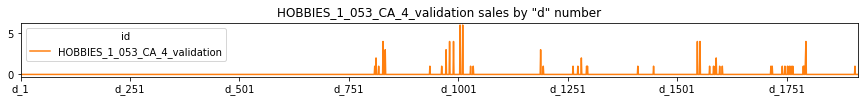

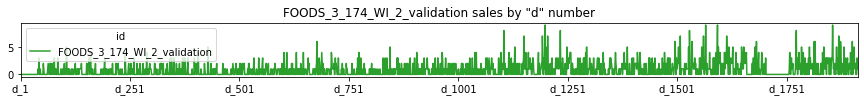

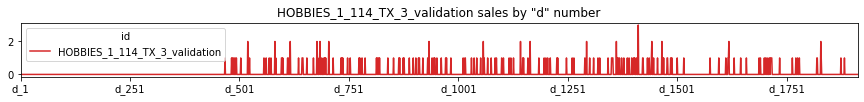

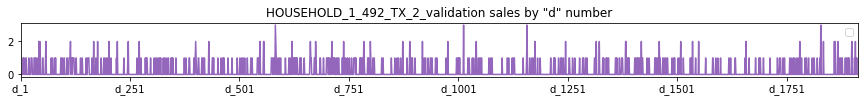

In [10]:
# построим как выглядит временной ряд продеж для произвольных 5 товаров

d_cols = [c for c in sales_df.columns if 'd_' in c] # sales data columns

group_of_items = sales_df['id'].values
num_to_select = 5
list_of_random_items = random.sample(list(group_of_items), num_to_select)

for item_id in list_of_random_items:
    sales_df.loc[sales_df['id'] == item_id].set_index('id')[d_cols].T\
    .plot(figsize=(15, 1), title='{} sales by "d" number'.format(item_id), 
         color=next(color_cycle))

plt.legend('')
plt.show()

Как видно, временные ряды продаж разных товаров очень разнородны. Помимо этого, у них есть 2 особенности: большой процент значений равных 0 и в целом дискретность ряда.

В связи с этим можно исследовать следующие 2 вещи: 

1. Есть ли в данных какой-то фактор, объясняющий такую большую долю 0 значений?

2. Насколько эти временные ряды вообще взаимосвязаны друг с другом? Можно ли выделить кластеры сильно скоррелированных временных рядов?

Для начала, посмотрим, какие факторы определяют поведение временного ряда.

Всего есть 3 категррии товаров: 'HOBBIES', 'HOUSEHOLD', 'FOODS'

3 типа штатов: 'CA' 'TX' 'WI'

10 магазинов: 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'

7 типов департаментов: 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'

Общая структура данных (взято из Competition Guide: https://mofc.unic.ac.cy/m5-competition/):

<img src="data_diagram.png">

Календарные мероприятия (30 штук): 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'

Меропреятия делятся на 4 типа: 'Sporting', 'Cultural', 'National', 'Religious'


Существующие категории: ['HOBBIES' 'HOUSEHOLD' 'FOODS']


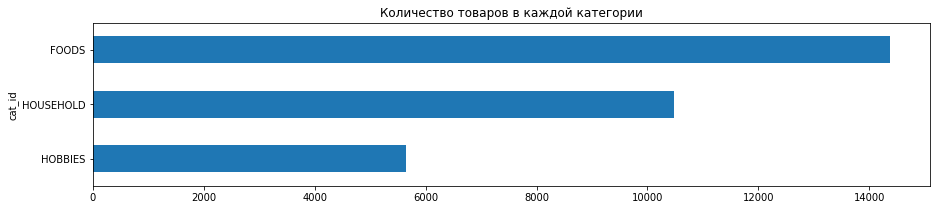

In [11]:
print('Существующие категории:', sales_df.cat_id.unique())

sales_df.groupby('cat_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров в каждой категории')
plt.show()

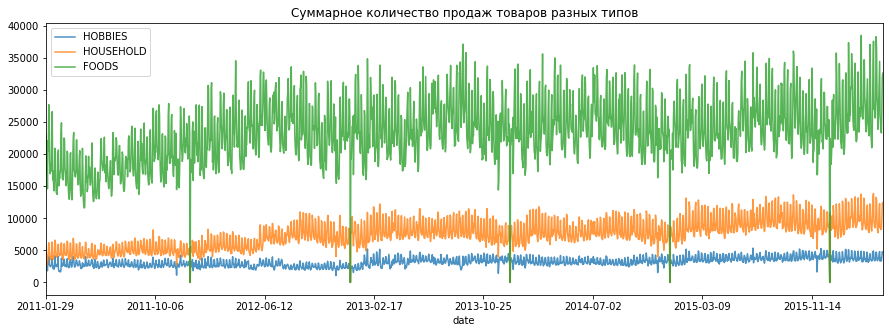

In [12]:
past_sales = sales_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')


for i in sales_df['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5),
                                           alpha=0.8,
                                           title='Суммарное количество продаж товаров разных типов')
plt.legend(sales_df['cat_id'].unique())
plt.show()

В совокупных продажах по категориям явно прослеживаются, тренд, сезонность и периодичность.

Так же невооруженным глазом можно заметить явные выбросы в покупке еды в районе Рождества, что довольно естественно.

Типы штатов: ['CA' 'TX' 'WI']


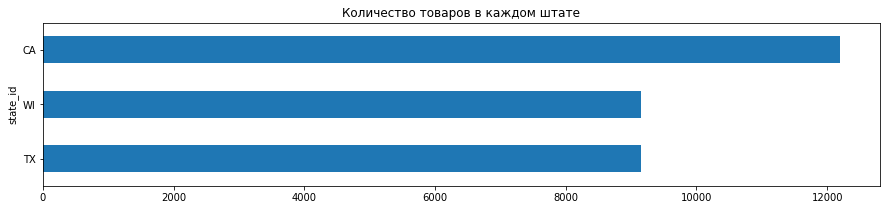

In [13]:
print('Типы штатов:', sales_df.state_id.unique())

sales_df.groupby('state_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров в каждом штате')
plt.show()

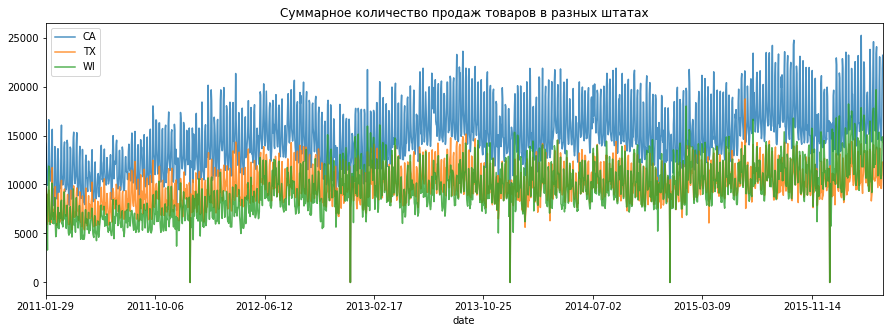

In [14]:
for i in sales_df['state_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5),
                                           alpha=0.8,
                                           title='Суммарное количество продаж товаров в разных штатах')
plt.legend(sales_df['state_id'].unique())
plt.show()

Типы штатов: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


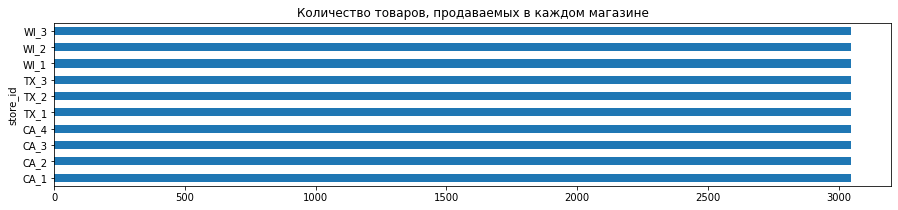

In [15]:
len(sales_df.store_id.unique())
print('Типы штатов:', sales_df.store_id.unique())

sales_df.groupby('store_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров, продаваемых в каждом магазине')
plt.show()

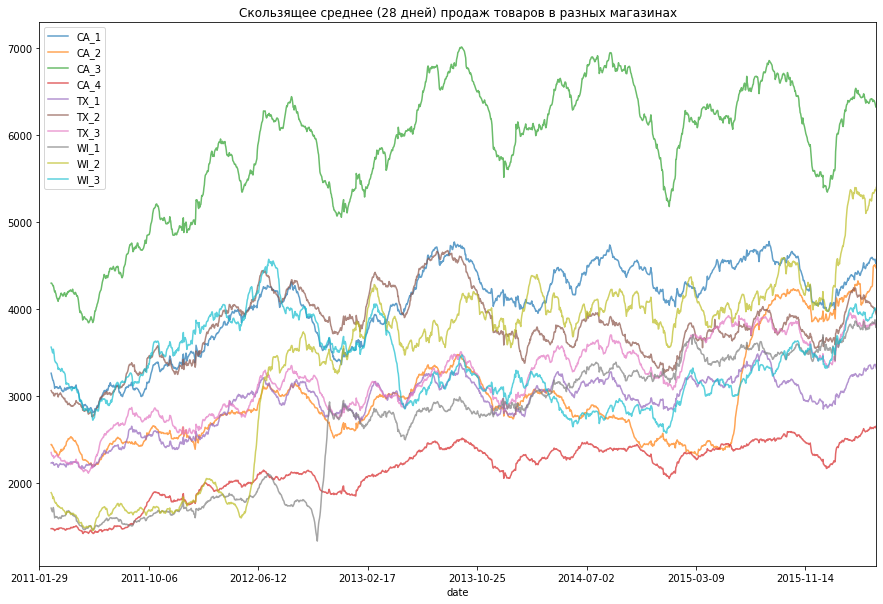

In [16]:
for i in sales_df['store_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).rolling(28).mean().plot(figsize=(15, 10),
                                           alpha=0.7,
                                           title='Скользящее среднее (28 дней) продаж товаров в разных магазинах')
plt.legend(sales_df['store_id'].unique())
plt.show()

### Тепловая карта календаря

Как видно из предыдущих графиков, у нас есть явная периодичность в данных, давайте посмотрим, что с ними происходит в различные дни.

In [17]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

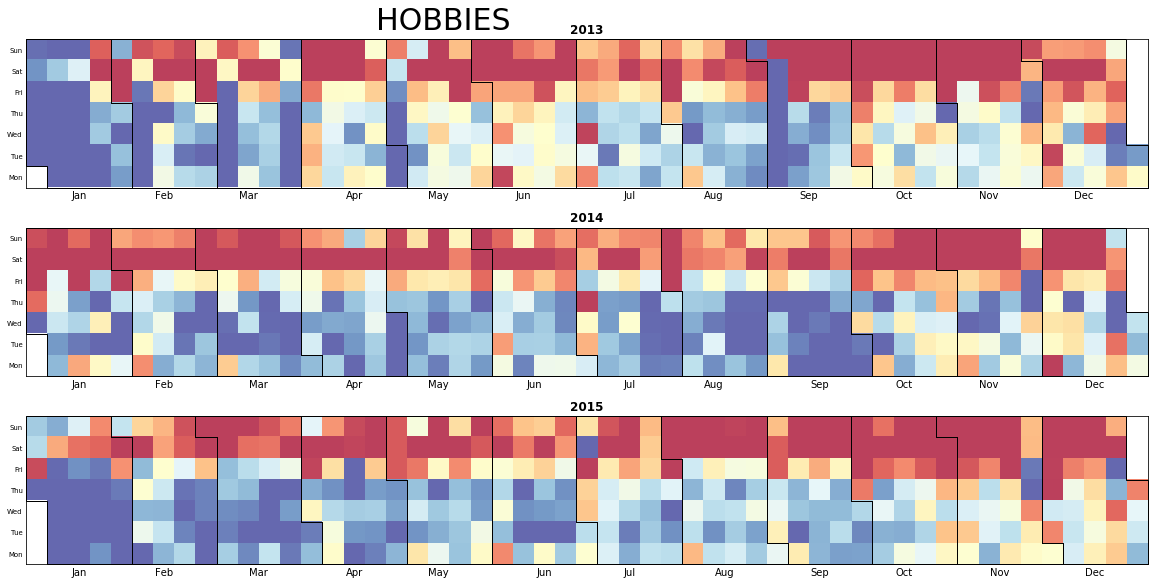

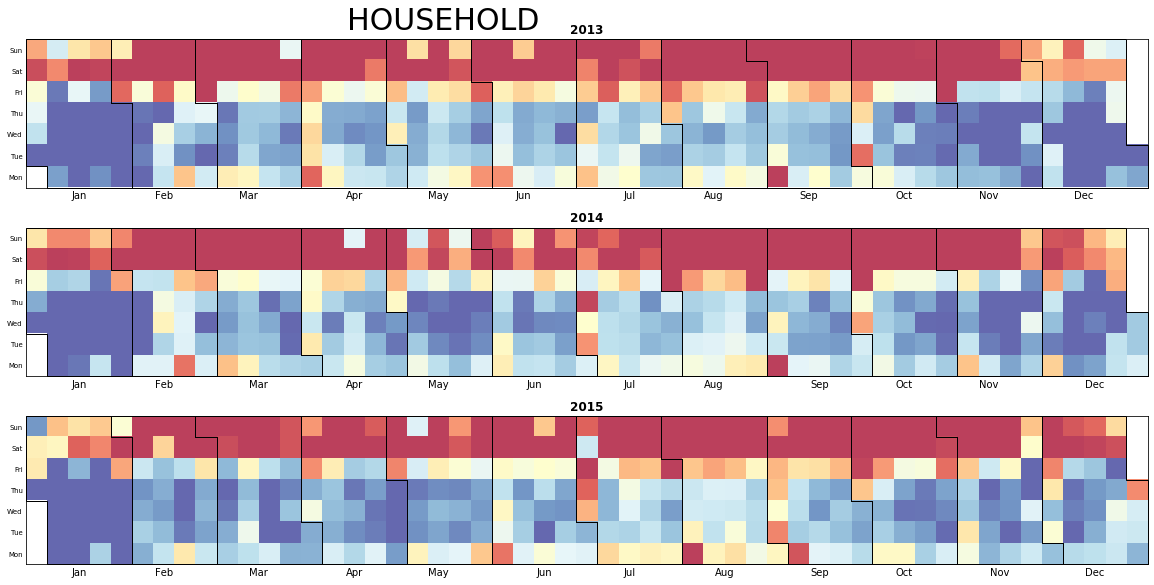

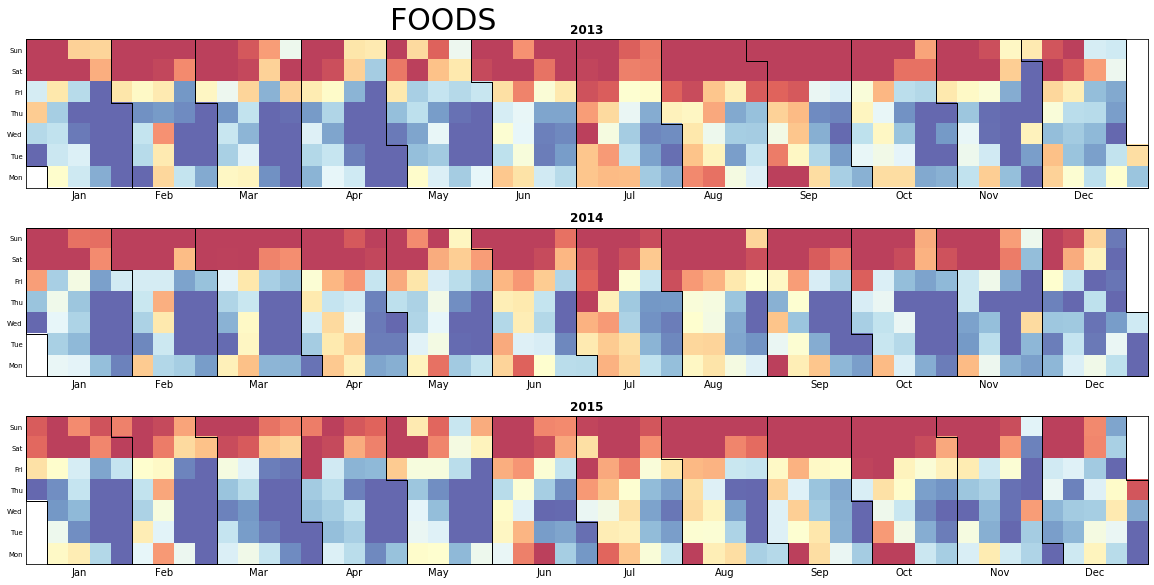

In [18]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in sales_df['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

Наблюдения:

1) Высокая активность по покупкам в выходные, и низкая в начале недели

2) Начало и конец года сопровождаются спадом в активности (это можно объяснить тем, что люди тратят много денег на подарки)

3) В середине года (конец весны - лето) активность в нерабочие дни более высокая (период отпусков)

### Events

Давайте посмотрим, как меняется распределение количества покупок в особые дни

In [19]:
calendar_df.date = pd.to_datetime(calendar_df.date)
past_sales_df = past_sales.reset_index()

event_df = pd.merge(past_sales_df, calendar_df, left_on='date', right_on='date')

In [20]:
ca_hh_names = [name for name in event_df.columns if '_CA_' in name and 'HOUSEHOLD_' in name]
ca_hobb_names = [name for name in event_df.columns if '_CA_' in name and 'HOBBIES_' in name]
ca_foods_names = [name for name in event_df.columns if '_CA_' in name and 'FOODS_' in name]

tx_hh_names = [name for name in event_df.columns if '_TX_' in name and 'HOUSEHOLD_' in name]
tx_hobb_names = [name for name in event_df.columns if '_TX_' in name and 'HOBBIES_' in name]
tx_foods_names = [name for name in event_df.columns if '_TX_' in name and 'FOODS_' in name]

wi_hh_names = [name for name in event_df.columns if '_WI_' in name and 'HOUSEHOLD_' in name]
wi_hobb_names = [name for name in event_df.columns if '_WI_' in name and 'HOBBIES_' in name]
wi_foods_names = [name for name in event_df.columns if '_WI_' in name and 'FOODS_' in name]

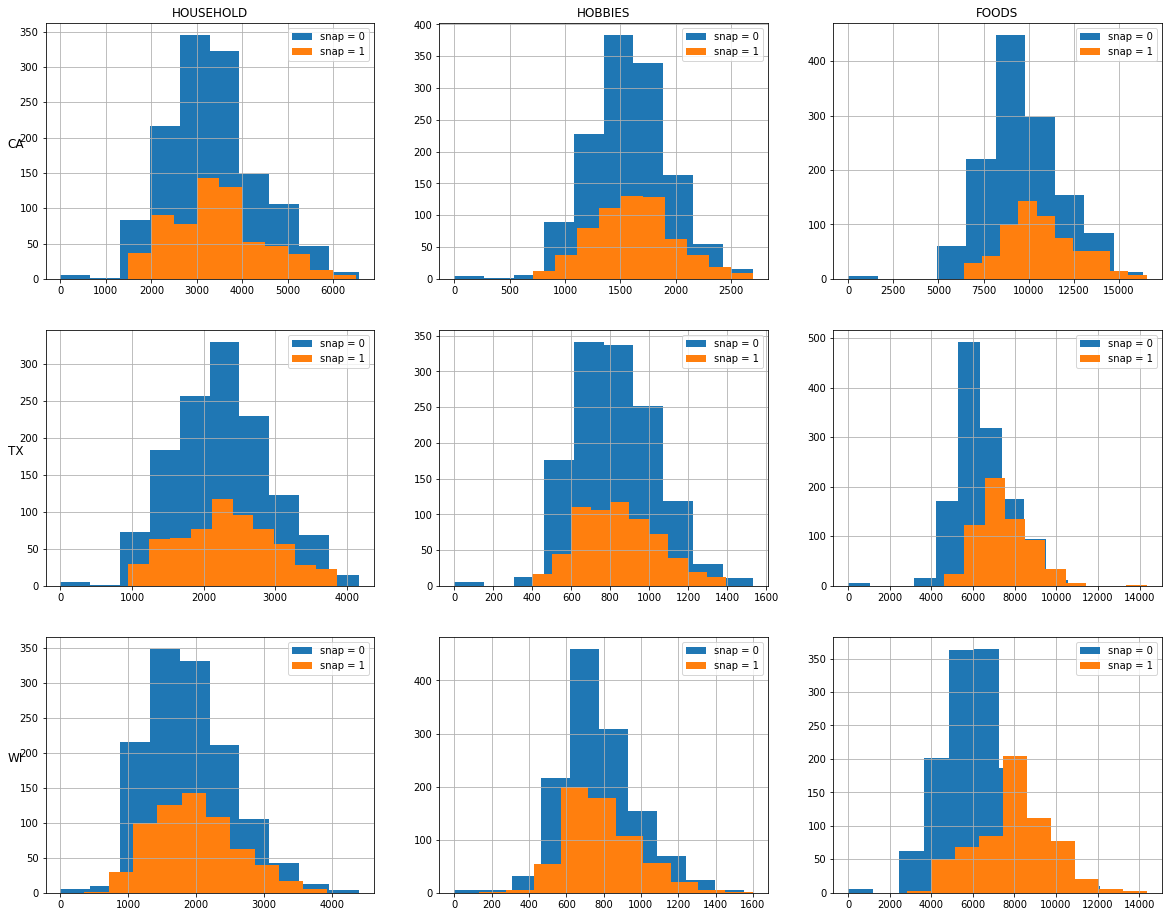

In [21]:
fig, axs = plt.subplots(3, 3, figsize = (20, 16))

event_df.loc[event_df.snap_CA == 0, ca_hh_names].sum(axis=1).hist(ax = axs[0, 0], label = 'snap = 0')
event_df.loc[event_df.snap_CA == 1, ca_hh_names].sum(axis=1).hist(ax = axs[0, 0], label = 'snap = 1')
axs[0, 0].legend()

event_df.loc[event_df.snap_CA == 0, ca_hobb_names].sum(axis=1).hist(ax = axs[0, 1], label = 'snap = 0')
event_df.loc[event_df.snap_CA == 1, ca_hobb_names].sum(axis=1).hist(ax = axs[0, 1], label = 'snap = 1')
axs[0, 1].legend()

event_df.loc[event_df.snap_CA == 0, ca_foods_names].sum(axis=1).hist(ax = axs[0, 2], label = 'snap = 0')
event_df.loc[event_df.snap_CA == 1, ca_foods_names].sum(axis=1).hist(ax = axs[0, 2], label = 'snap = 1')
axs[0, 2].legend()

event_df.loc[event_df.snap_TX == 0, tx_hh_names].sum(axis=1).hist(ax = axs[1, 0], label = 'snap = 0')
event_df.loc[event_df.snap_TX == 1, tx_hh_names].sum(axis=1).hist(ax = axs[1, 0], label = 'snap = 1')
axs[1, 0].legend()

event_df.loc[event_df.snap_TX == 0, tx_hobb_names].sum(axis=1).hist(ax = axs[1, 1], label = 'snap = 0')
event_df.loc[event_df.snap_TX == 1, tx_hobb_names].sum(axis=1).hist(ax = axs[1, 1], label = 'snap = 1')
axs[1, 1].legend()

event_df.loc[event_df.snap_TX == 0, tx_foods_names].sum(axis=1).hist(ax = axs[1, 2], label = 'snap = 0')
event_df.loc[event_df.snap_TX == 1, tx_foods_names].sum(axis=1).hist(ax = axs[1, 2], label = 'snap = 1')
axs[1, 2].legend()


event_df.loc[event_df.snap_WI == 0, wi_hh_names].sum(axis=1).hist(ax = axs[2, 0], label = 'snap = 0')
event_df.loc[event_df.snap_WI == 1, wi_hh_names].sum(axis=1).hist(ax = axs[2, 0], label = 'snap = 1')
axs[2, 0].legend()

event_df.loc[event_df.snap_WI == 0, wi_hobb_names].sum(axis=1).hist(ax = axs[2, 1], label = 'snap = 0')
event_df.loc[event_df.snap_WI == 1, wi_hobb_names].sum(axis=1).hist(ax = axs[2, 1], label = 'snap = 1')
axs[2, 1].legend()

event_df.loc[event_df.snap_WI == 0, wi_foods_names].sum(axis=1).hist(ax = axs[2, 2], label = 'snap = 0')
event_df.loc[event_df.snap_WI == 1, wi_foods_names].sum(axis=1).hist(ax = axs[2, 2], label = 'snap = 1')
axs[2, 2].legend()


rows = ['CA', 'TX', 'WI']
cols = ['HOUSEHOLD', 'HOBBIES', 'FOODS']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

plt.show()

Как видно, распределения в обычные дни и в особые существенно отличаются, по этому их следует учитывать отдельно

### Посмотрим как временные ряды скоррелированы между собой

In [ ]:
hobbies_cols = [col for col in past_sales.columns if 'HOBBIES' in col]
foods_cols = [col for col in past_sales.columns if 'FOODS' in col]
household_cols = [col for col in past_sales.columns if 'HOUSEHOLD' in col]

In [ ]:
past_sales.iloc[-365:]

In [ ]:
#  посмотрим корреляцию продаж товаров за 365 дней
corr = past_sales[hobbies_cols].iloc[-365:].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = past_sales[foods_cols].iloc[-365:].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = past_sales[household_cols].iloc[-365:].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Как видно, продажи товаров очень слабо скоррелированы, тепловые карты белые.

Следовательно, товары имеет смысл рассматривать по отдельности

In [ ]:
corr = past_sales[hobbies_cols].iloc[-365:].T.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = past_sales[foods_cols].iloc[-365:].T.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = past_sales[household_cols].iloc[-365:].T.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Pipeline

Есть 2 ортогональных подхода к построению модели прогнозирования подаж:

1. Регрессия. Моделировать данные, как временной ряд (использовать тренд, цикличность и периодичность в данных)
2. Классификация. Как можно заметить, предсказываемые значения - это дискретные числа от 0. Таким образом, мы можем разбить их на k интервалов (классов) и прогнозировать попадание в тот или иной класс.

Данные подходы можно в дальнейшем эффективно комбинировать друг с другом. Например, прогнозировать продажи для обычных и более предсказуемых дней с помощью регрессии, а для дней, в которые потребительские привычки сильно отличаются (Рождество, Пасха, Суперкубок и т.д.) строить отдельные модели классификации.

In [73]:
# borrowed from: https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features
from typing import Union
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [74]:
%time 

train_df = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:].copy()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
# del train_fold_df, train_df, calendar, prices

CPU times: user 14 µs, sys: 14 µs, total: 28 µs
Wall time: 826 µs


In [75]:
# Тестируем validation score: подаем случайные целочисленные значения от 0 до 3
valid_preds = np.random.randint(4, size=valid_fold_df.shape)
e.score(valid_preds)

2.480907933167013

### Baseline solution

Мы будем двигаться от простого к сложному.
Для начала построим простое бейзлайн решение, чтобы в дальнейшем, отталкиваясь от него строить более сложные модели, добавлять новые признаки и оценивать их эффективность.

*Идея бейзлайн решения:* давайте для каждого товара прогнозировать константу продаж. Такую модель очень быстро построить, но она должна давать сравнительно неплохой результат. 

Так как метрика для каждого отдельного временного ряда: RMSSE, то оптимальной константой будет среднее. Мы можем варьировать период за который будет считаться среднее, чтобы наш прогноз меньше зависел от более старых продаж.

In [76]:
pred_mean = np.repeat(np.array([past_sales.mean().values]).T, repeats=28, axis=1)
    
e.score(pred_mean)

1.6917552501800248

Как видно, значение уже лучше случайного предсказания. Попробуем пороварьировать период, за который мы производим усреднение.

WRMSSEE = 1.1078274455926023 при длине окна 101


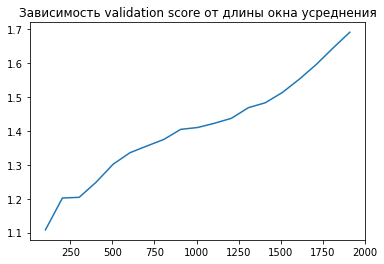

In [77]:
num_splits = 20

start_date_index_list = [int(i) for i in np.linspace(1, len(past_sales), 
                                                     num=num_splits)[:-1]]

score_list = []
for start_date_index in start_date_index_list:
    pred_mean = np.repeat(np.array([past_sales.values[start_date_index:,:].mean(axis=0)]).T, 
                          repeats=28, axis=1)
    score_list.append(e.score(pred_mean))

window_len = [len(past_sales) - i for i in start_date_index_list]
plt.plot(window_len, score_list)
plt.title('Зависимость validation score от длины окна усреднения')

print('WRMSSEE = {} при длине окна {}'.format(min(score_list), window_len[np.array(score_list).argmin()]))

WRMSSE = 1.0698912098303412 при длине окна 22


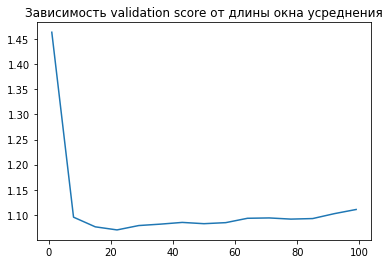

In [78]:
# Попробуем длину окна меньше 100

start_date_index_list = [len(past_sales) - int(i) for i in range(1, 100, 7)]

score_list = []
for start_date_index in start_date_index_list:
    pred_mean = np.repeat(np.array([past_sales.values[start_date_index:,:].mean(axis=0)]).T, 
                          repeats=28, axis=1)
    score_list.append(e.score(pred_mean))
    
window_len = [len(past_sales) - i for i in start_date_index_list]
plt.plot(window_len, score_list)
plt.title('Зависимость validation score от длины окна усреднения')

print('WRMSSE = {} при длине окна {}'.format(min(score_list), window_len[np.array(score_list).argmin()]))

### Linear model pipeline

Как показывает наш константный бейзлайн, он работает неплохо (1.07 CV WRMSSE, в то время, как лучшее публичное решение имеет 0.46 LB WRMSSE).
Попробуем развить идею. Графики суммарных продаж показыват, что в данных есть положительный тренд от года к году (это можно связать с экономическим ростом США). Поэтому вместо константы будем строить линейную модель по номеру дня, чтобы учесть этот тренд. 
Затем будем постепенно добавлять новые признаки к модели:
1. День недели (в данных наблюдается недельная цикличность)
2. День месяца (месячная цикличность - зарплатный период)
3. Особые дни 
4. Тип особого дня

In [79]:
from sklearn.linear_model import LinearRegression

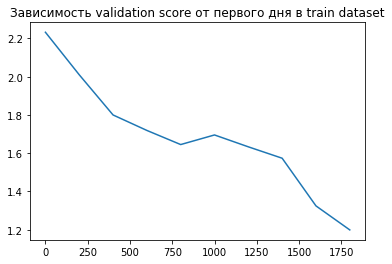

In [80]:
first_days = [i for i in range(0, 2000, 200)]
scores = []

for i in first_days:
    train_fold_df = train_df.T.iloc[6 + i:-28].reset_index().drop('index', axis=1)
    valid_fold_df = train_df.T.iloc[-28:].reset_index().drop('index', axis=1)

    X_train = np.array([train_fold_df.index.values]).T
    X_test = np.array([valid_fold_df.index.values]).T

    pread_lr = []

    for i in range(train_fold_df.shape[1]):
        y_train = train_fold_df.iloc[:, i].values
        y_test = valid_fold_df.iloc[:, i].values

        reg = LinearRegression().fit(X_train, y_train)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

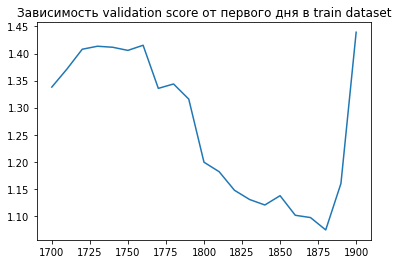

In [81]:
first_days = [i for i in range(1700, 1901, 10)]
scores = []

for i in first_days:
    train_fold_df = train_df.T.iloc[6 + i:-28].reset_index().drop('index', axis=1)
    valid_fold_df = train_df.T.iloc[-28:].reset_index().drop('index', axis=1)

    X_train = np.array([train_fold_df.index.values]).T
    X_test = np.array([valid_fold_df.index.values]).T

    pread_lr = []

    for i in range(train_fold_df.shape[1]):
        y_train = train_fold_df.iloc[:, i].values
        y_test = valid_fold_df.iloc[:, i].values

        reg = LinearRegression().fit(X_train, y_train)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [82]:
min(scores)

1.0739926650737863

Как видно, результат хуже константного бейзлайна. Добавим больше информации о днях

In [83]:
d_cols = [c for c in train_df.columns if 'd_' in c]

sales_history_df = train_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')

calendar_df.date = pd.to_datetime(calendar_df.date)
full_df = pd.merge(sales_history_df, calendar_df, left_on='date', right_on='date')

In [84]:
full_df.month = event_df.month.astype(str)
category_columns = ['weekday', 'month', 'event_type_1', 'event_name_1']

data_category = pd.get_dummies(full_df[category_columns])
data_category.head()

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_1,month_10,month_11,...,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
full_df.drop(category_columns, axis=1, inplace=True)
full_df = pd.concat([full_df, data_category], axis=1)

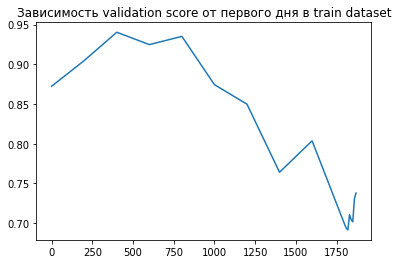

In [86]:
data_cols = [col for col in full_df.columns if 'weekday_' in col] + ['index']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1800, 1880, 10)]
scores = []

for i in first_days:
    X_train, X_test, y_train, y_test = X[i:-28], X[-28:], y[i:-28], y[-28:]

    pread_lr = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_test_cur = y_test[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [87]:
min(scores)

0.6914626955896905

Добавление информации о дне недели существенно улучшило результат. Теперь добавим информацию о месяце и посмотрим, как он изменится

In [ ]:
data_cols = [col for col in full_df.columns if 'weekday_' in col or 'month_' in col] + ['index']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1800, 1880, 10)]
scores = []

for i in first_days:
    X_train, X_test, y_train, y_test = X[i:-28], X[-28:], y[i:-28], y[-28:]

    pread_lr = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_test_cur = y_test[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [ ]:
min(scores)

Как видно, месяц не на столько репрезентативный признак, результат ухудшился. Попробуем вместо него использовать флаг особого дня (snap_XX)

In [ ]:
data_cols = [col for col in full_df.columns if 'weekday_' in col] + ['index'] + ['snap_CA', 'snap_TX', 'snap_WI'] 
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1800, 1880, 10)]
scores = []

for i in first_days:
    X_train, X_test, y_train, y_test = X[i:-28], X[-28:], y[i:-28], y[-28:]

    pread_lr = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_test_cur = y_test[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [ ]:
min(scores)

Результат улучшился. Попробуем теперь добавить информацию о типе мероприятия.

In [ ]:
data_cols = [col for col in full_df.columns if 'weekday_' in col or 'event_type_1' in col]\
                    + ['index'] + ['snap_CA', 'snap_TX', 'snap_WI'] 
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1800, 1880, 10)]
scores = []

for i in first_days:
    X_train, X_test, y_train, y_test = X[i:-28], X[-28:], y[i:-28], y[-28:]

    pread_lr = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_test_cur = y_test[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_test))

    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [ ]:
min(scores)

Как видно результат немного улучшился.

Проблема линейной регрессии заключается в том, что она ищет решение в очень узком классе данных: взвешенная линейная сумма признаков.
На практике данные могут иметь куда более сложную структуру.

Попробуем более продвинутый класс алгоритмов: градиентный бустинг.

### LightGBM

Один из наиболее используемых методов для решения подобных задач - это градиентный бустинг.
Попробуем применить его здесь.



In [25]:
d_cols = [c for c in train_df.columns if 'd_' in c]

sales_history_df = train_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')

calendar_df.date = pd.to_datetime(calendar_df.date)
full_df = pd.merge(sales_history_df, calendar_df, left_on='date', right_on='date')

In [26]:
train_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [68]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.05,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 200,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8, 
    'num_leaves': 63,
    "max_bin": 512,
    "num_iterations": 500,
    "n_estimators": 500
}

In [69]:
full_df = full_df.apply(LabelEncoder().fit_transform)

In [ ]:
data_cols = ['index', 'wday', 'month', 'year', 'event_type_1', 'event_name_1', 
             'event_type_2', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [1180] #[i for i in range(0, 2000, 300)] + [i for i in range(1800, 1880, 30)]
scores = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]
    


    pred_gbm = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]
        
        lgb_train = lgb.Dataset(X_train, y_train_cur)
        lgb_eval = lgb.Dataset(X_val, y_val_cur, reference=lgb_train)
        
        gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_train,  # eval training data
                feature_name=data_cols,
                categorical_feature=[1, 2, 3, 4, 5, 6, 7])
        
        
        pred_gbm.append(gbm.predict(X_test))

    pred_gbm_np = np.array(pred_gbm)
    pred_gbm_np[pred_gbm_np < 0] = 0

    scores.append(e.score(pred_gbm_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [71]:
scores

[1.1702673323806314]

In [ ]:
y[-56:-28]